# Bonus Lab 4 "solutions"

RNNs in Keras for time series prediction on global temperature data.

## Imports


In [2]:
# Data and Datasets
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Validation methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Metrics
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Regression metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error

# Tensorflow (and Keras)
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.utils import to_categorical

# Classifiers
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# Hyper-parameter optimisation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Feature selection & feature engineering
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

# Time series analysis
!pip3 install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator

# Stats
from scipy.stats import randint as sp_randint
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import shapiro     # Shapiro Wilk
from scipy.stats import normaltest  # D’Agostino’s K^2
from scipy.stats import anderson    # Anderson-Darling
from scipy.stats import ttest_ind    # independent student t-test; assumes normality
from scipy.stats import mannwhitneyu # non-parametric; doesn't assume normality

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.tree import export_graphviz

# Utils
import pprint
import numpy as np
from time import time
from datetime import datetime
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 696.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.7/233.7 KB 952.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 769.6 kB/s eta 0:00:00 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 21.0
    Uninstalling packaging-21.0:
      Successfully uninstalled packaging-21.0


## Utility functions

In [3]:
#scaler = Normalizer()
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
    
def scale_data(data):
    global scaler
    return scaler.fit_transform(data.reshape(-1,1)).flatten()

def de_scale(data):
    global scaler
    return scaler.inverse_transform(data.reshape(-1,1)).flatten()

In [4]:
def get_train_test_split(data, test_proportion=0.2):
    """
    Does an ordered training-test split, taking the first proportion of the dataset as 
    the training set, and the second proportion as the test set, according to the 'test_proportion'
    argument.
    """
    split_idx = int(data.size*(1-test_proportion))
    training_data = data[:split_idx]
    testing_data = data[split_idx:]
    
    return training_data, testing_data

def get_y_train_test(training_data, testing_data, time_window):
    """
    Get data samples of the training and test data that align with the predicted
    outputs; i.e., excludes the first 'time_window' number of samples that are
    used to make the first prediction.
    """
    y_train = training_data[time_window:]
    y_test = testing_data[time_window:]
    
    return y_train, y_test

def get_date_labels(df, time_window, test_proportion=0.2):
    """
    Get the date labels, aligning with the time period of predictions; i.e., excludes 
    the first 'time_window' number of samples that are used to make the first prediction.
    """
    date_list = df.index.to_numpy()
    date_list_tr, date_list_test = get_train_test_split(date_list, test_proportion)
    
    return get_y_train_test(date_list_tr, date_list_test, time_window)

In [5]:
def print_results(y_train, y_pred_tr, y_test, y_pred_test, de_scaled=True):
    """
    Calculates and prints the results as Mean Squared Error (MSE),
    on both the training and test sets.
    """
    if (de_scaled):
        mse_tr = mean_squared_error(de_scale(y_train), de_scale(y_pred_tr))
        mse_test = mean_squared_error(de_scale(y_test), de_scale(y_pred_test))
    else:
        mse_tr = mean_squared_error(y_train, y_pred_tr)
        mse_test = mean_squared_error(y_test, y_pred_test)

    print("Squared MSE (train):  %0.2f" % (math.sqrt(mse_tr)))
    print("Squared MSE (test):   %0.2f" % (math.sqrt(mse_test)))

def plot_loss(loss):
    """
    Plots a line chart for the loss per epoch during training.
    """
    plt.plot(loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per epoch')
    
def plot_results(y_train, y_pred_tr, y_test, y_pred_test, training_dates, testing_dates, de_scaled=True):
    """
    Plots a line graph of the actual vs predicted results.
    """
    predictions = np.append(y_pred_tr, y_pred_test)
    actual = np.append(y_train, y_test)
    all_dates = np.append(training_dates, testing_dates)
    
    if (de_scaled):
        predictions = de_scale(predictions)
        actual = de_scale(actual)
    
    # Plots a figure for the entire range; training + test range
    # Adds a black dotted line to mark the separation from training & test sets
    plt.figure(figsize=(16, 7))
    plt.plot(all_dates, actual)
    plt.plot(all_dates, predictions)
    plt.axvline(x=y_train.size, linewidth=2, linestyle='--', color='black')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Time')
    plt.ylabel('Mean temperature')
    plt.title('Actual vs forecast mean temperature (vertical line separates training and test sets)')
    
    # Plots a figure for the test range only
    plt.figure(figsize=(16, 7))
    if (de_scaled):
        plt.plot(testing_dates, de_scale(y_test))
        plt.plot(testing_dates, de_scale(y_pred_test))
    else:
        plt.plot(testing_dates, y_test)
        plt.plot(testing_dates, y_pred_test)
    plt.title('Actual vs forecast mean temperature (on test set)')
    plt.xlabel('Time')
    plt.ylabel('Mean temperature')
    plt.legend(['Actual', 'Predictions'])

## Loading the dataset

Source: https://datahub.io/core/global-temp

"Global Temperature Time Series. Data are included from the GISS Surface Temperature (GISTEMP) analysis and the global component of Climate at a Glance (GCAG). Two datasets are provided: 1) global monthly mean and 2) annual mean temperature anomalies in degrees Celsius from 1880 to the present"

In [7]:
temp_df = pd.read_csv('global_temp_monthly.csv', parse_dates=["Date"])
temp_df = temp_df.rename(columns={"Mean": "Mean temp"})
temp_df.head()

,Source,Date,Mean temp
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [6]:
# CREATING A DATAFRAME FOR JUST ONE OF THE SOURCES HERE TO WORK WITH (GISTEMP)
# temp_gcag_df = temp_df.loc[temp_df['Source'] =='GCAG'].drop(['Source'], axis=1)
temp_gistemp_df = temp_df.loc[temp_df['Source'] == 'GISTEMP'].drop(['Source'], axis=1)

# Change day to 1st of the month, in order to be able to use a monthly frequency type
temp_gistemp_df['Date'] = temp_gistemp_df['Date'].apply(lambda dt: dt.replace(day=1))

# Setting index
temp_gistemp_df = temp_gistemp_df.set_index('Date')
temp_gistemp_df.index.freq='-1MS'

# Sorting the index
temp_gistemp_df = temp_gistemp_df.sort_index()
temp_gistemp_df.head()

,Mean temp
Date,
1880-01-01,-0.30
1880-02-01,-0.21
1880-03-01,-0.18
1880-04-01,-0.27
1880-05-01,-0.14


In [7]:
temp_gistemp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1644 entries, 1880-01-01 to 2016-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mean temp  1644 non-null   float64
dtypes: float64(1)
memory usage: 25.7 KB


In [8]:
temp_gistemp_df.describe()

,Mean temp
count,1644.000000
mean,0.024380
std,0.343709
min,-0.780000
25%,-0.230000
50%,-0.050000
75%,0.230000
max,1.350000


<AxesSubplot:xlabel='Time line', ylabel='Mean temperature'>

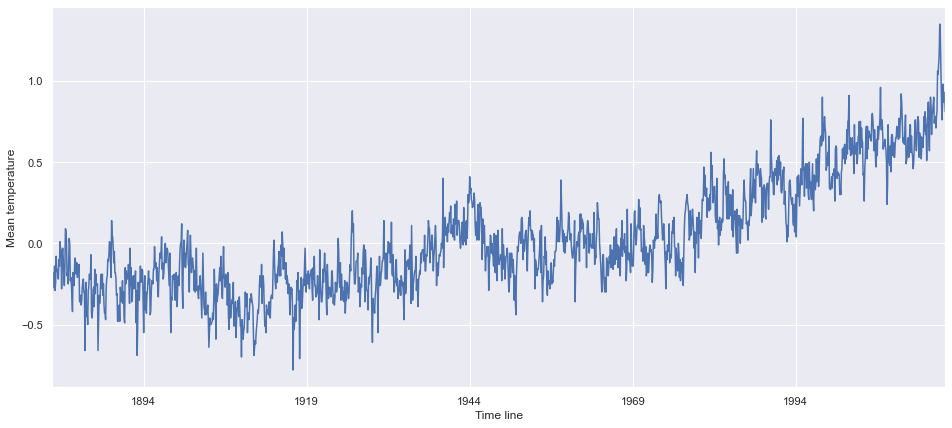

In [9]:
sns.set() # will use seaborn styling for plots
plt.figure(figsize=(16, 7))
temp_gistemp_df['Mean temp'].plot(xlabel='Time line', ylabel='Mean temperature')

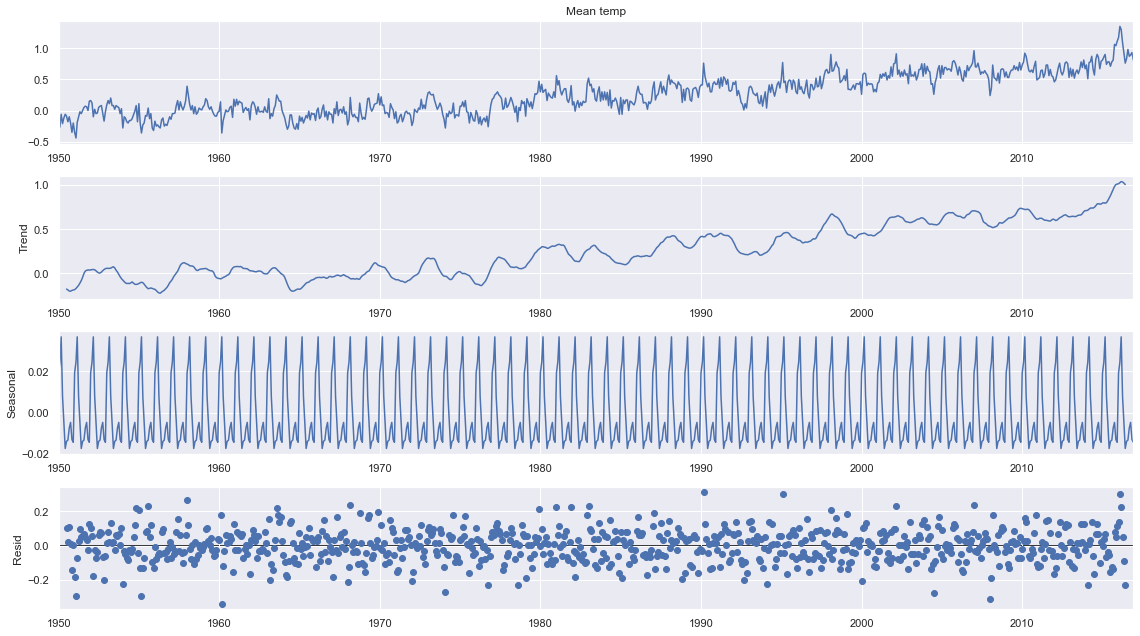

In [10]:
decomp_res = seasonal_decompose(temp_gistemp_df['Mean temp'].loc['1950-01-01':'2016-12-01'], model='additive')
plt.rcParams['figure.figsize'] = (16, 9)
decomp_res.plot()
plt.show()

## Processing the dataset

In [11]:
# Getting a numpy array of the temperatures
data = temp_gistemp_df['Mean temp'].to_numpy()

# Scaling values
data = scale_data(data)

# Splitting into a training and test set
test_proportion = 0.2
training_data, testing_data = get_train_test_split(data, test_proportion)

# Getting time series data objects
time_window = 12 # 12 month time window for the time series analysis
ts_generator_tr = TimeseriesGenerator(training_data, training_data, length=time_window, batch_size=1)
ts_generator_test = TimeseriesGenerator(testing_data, testing_data, length=time_window, batch_size=1)

# Getting the ground truth for calculating error and plotting results later
y_train, y_test = get_y_train_test(training_data, testing_data, time_window)

# Getting date labels for plotting results (for x-axis)
training_dates, testing_dates = get_date_labels(temp_gistemp_df, time_window, test_proportion)

## RNN model forecast

2021-12-12 12:43:24.118651: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
None
Training model ...
Epoch 1/10
1303/1303 [==============================] - 3s 1ms/step - loss: 0.0162
Epoch 2/10
1303/1303 [==============================] - 2s 1ms/step - loss: 0.0030
Epoch 3/10
1303/1303 [==============================] - 2s 1ms/step - loss: 0.0029
Epoch 4/10
1303/1303 [==============================] - 2s 1ms/step - loss: 0.0030
Epoch 5/10
1303/1303 [==============================] - 2s 1ms/step - loss: 0.0029
Epoch 6/10
1303

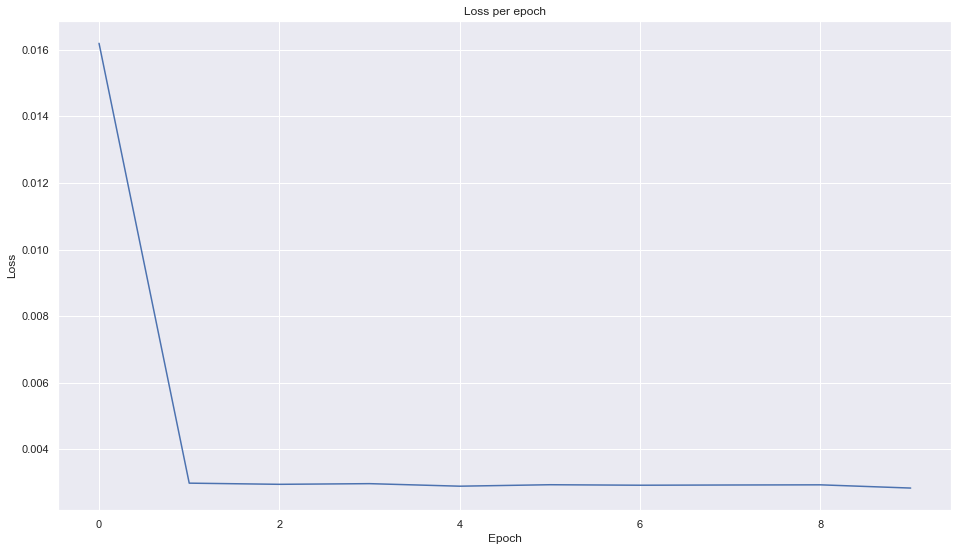

In [12]:
# Creating the model - same as above
# This needs to be in a function when using the KerasClassifier wrapper to turn this
# into a Scikit-Learn classifier
def rnn_model():
    
    model = Sequential()
    model.add(SimpleRNN(10, input_shape=(time_window,1), activation='relu'))
    model.add(Dense(1, activation='tanh'))

    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

model = rnn_model()
print(model.summary())

print("Training model ...")
model.fit(ts_generator_tr, epochs=10, batch_size=1, verbose=1)
print("Training complete!")
plot_loss(model.history.history['loss'])

Squared MSE (train):  0.12
Squared MSE (test):   0.30


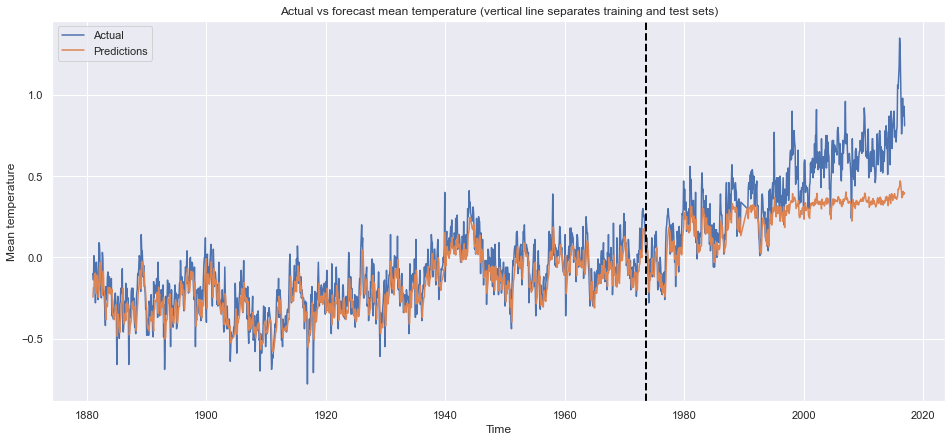

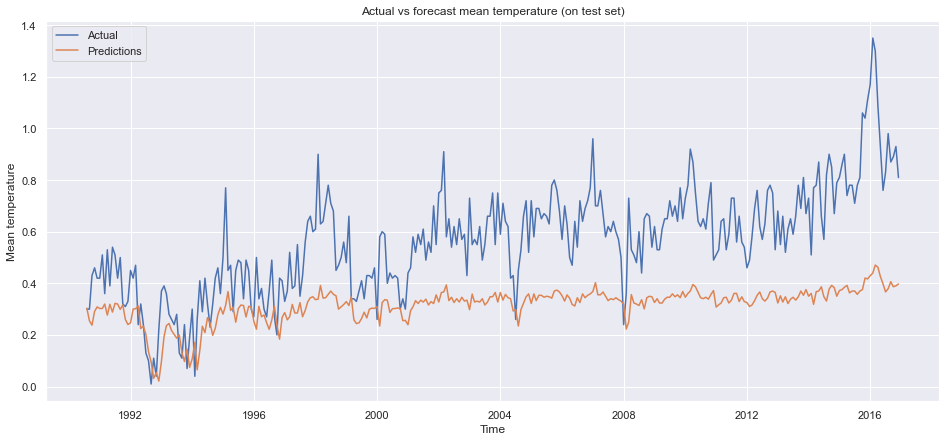

In [13]:
# Testing the model
y_pred_tr = model.predict(ts_generator_tr)
y_pred_test = model.predict(ts_generator_test)

# Outputting results
print_results(y_train, y_pred_tr, y_test, y_pred_test)
plot_results(y_train, y_pred_tr, y_test, y_pred_test, training_dates, testing_dates)

## LSTM model forecast

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None
Training model ...
Epoch 1/10
1303/1303 [==============================] - 4s 2ms/step - loss: 0.0066
Epoch 2/10
1303/1303 [==============================] - 3s 3ms/step - loss: 0.0031
Epoch 3/10
1303/1303 [==============================] - 3s 3ms/step - loss: 0.0031
Epoch 4/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.0029
Epoch 5/10
1303/1303 [==============================] - 3s 2ms/step - loss: 0.0029
Epoch 6/10
13

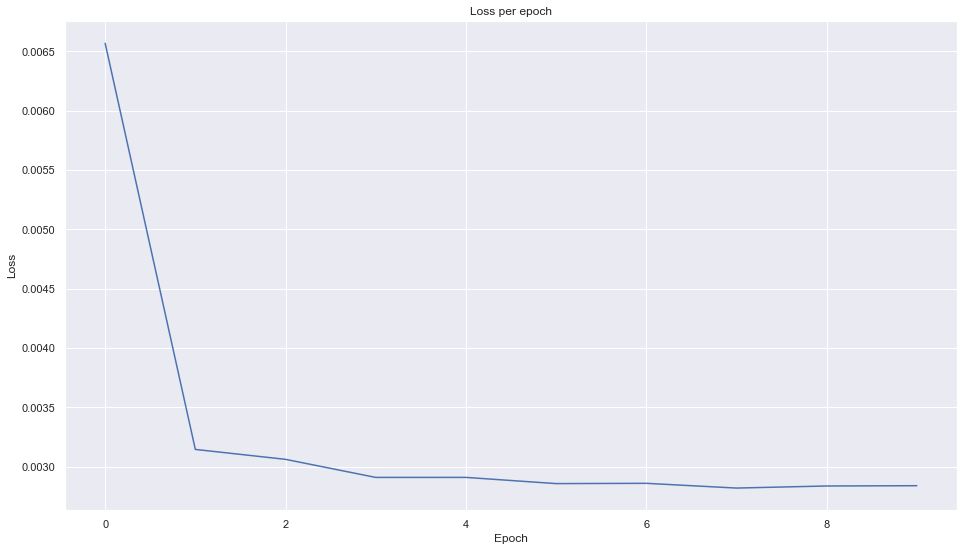

In [14]:
# Creating the model - same as above
# This needs to be in a function when using the KerasClassifier wrapper to turn this
# into a Scikit-Learn classifier
def lstm_model():
    model = Sequential()
    model.add(LSTM(10, input_shape=(time_window,1), activation='relu'))
    model.add(Dense(1, activation='tanh'))

    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

model = lstm_model()
print(model.summary())

print("Training model ...")
model.fit(ts_generator_tr, epochs=10, batch_size=1, verbose=1)
print("Training complete!")
plot_loss(model.history.history['loss'])

Squared MSE (train):  0.11
Squared MSE (test):   0.12


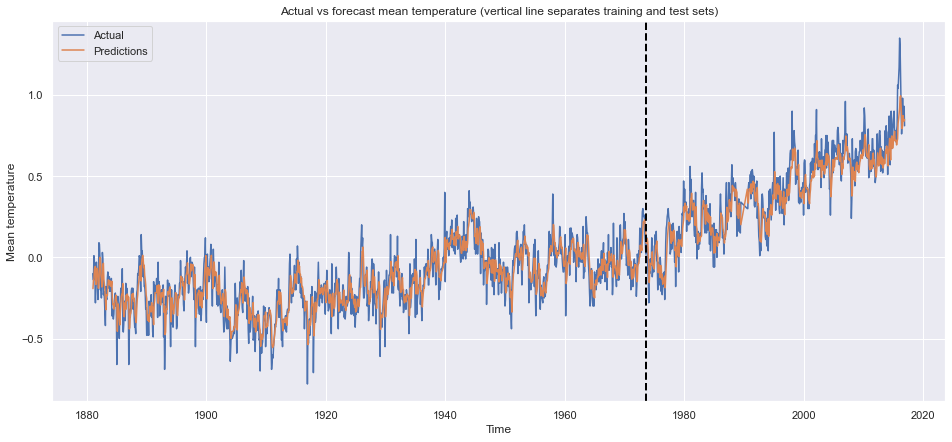

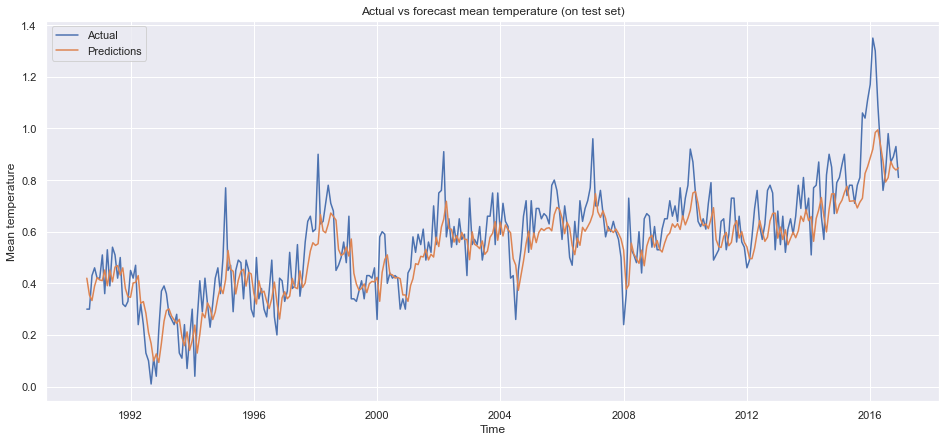

In [15]:
# Testing the model
y_pred_tr = model.predict(ts_generator_tr)
y_pred_test = model.predict(ts_generator_test)

# Outputting results
print_results(y_train, y_pred_tr, y_test, y_pred_test)
plot_results(y_train, y_pred_tr, y_test, y_pred_test, training_dates, testing_dates)